# CXR 이미지로 COVID19 분류

### DensNet

In [1]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

# 폴더 이동
%cd drive/My\ Drive/ai-school/CXR-pjt
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ai-school/CXR-pjt
/content/drive/My Drive/ai-school/CXR-pjt


In [2]:
# 라이브러리
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.utils import to_categorical
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf 
import numpy as np 
import glob as gb
import cv2
import os

In [3]:
# 하이퍼파라미터
epochs = 40
image_size = 224

LABELS = {'PNEUMONIA': 0, 'NORMAL': 1, 'COVID19': 2}

In [4]:
# path 설정 
path_data = "./Data-1/"


path_PNEUMONIA = path_data + "Pneumonia/"
path_NORMAL = path_data + "NORMAL/"
path_COVID19 = path_data + "COVID-19/"

In [5]:
# 확인
path_NORMAL

'./Data-1/NORMAL/'

In [6]:
# 이미지 확인
image = os.listdir(path_COVID19)[0]
plt.imread(path_COVID19 + image)
print(path_COVID19 + image)

./Data-1/COVID-19/COVID-19 (1).png


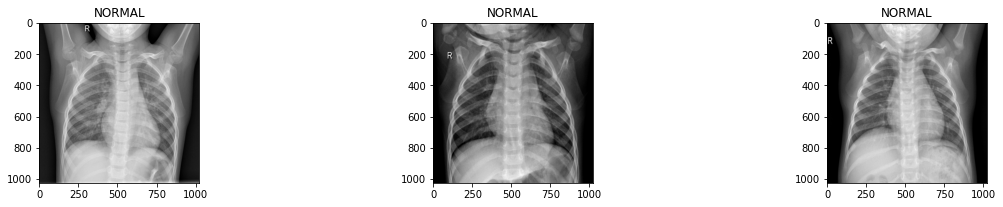

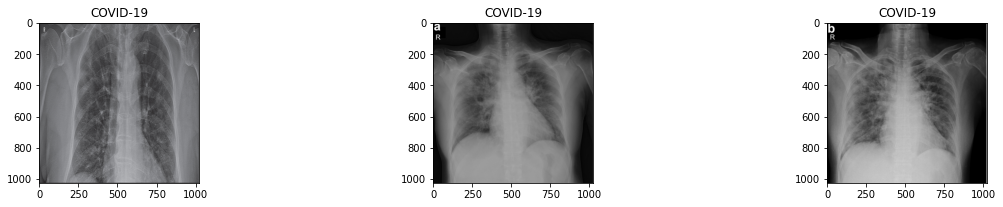

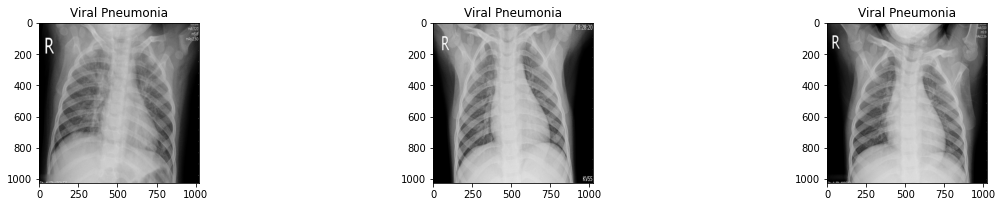

In [7]:
plt.figure(figsize=(20, 10))
for i in range(1, 4):
    plt.subplot(3, 3, i)
    img = plt.imread(path_NORMAL + f"NORMAL ({i}).png")
    plt.imshow(img, cmap='gray')
    plt.title("NORMAL")


plt.figure(figsize=(20, 10))
for i in range(1, 4):
    plt.subplot(3, 3, i)
    img = plt.imread(path_COVID19 + f"COVID-19 ({i}).png")
    plt.imshow(img, cmap='gray')
    plt.title("COVID-19")


plt.figure(figsize=(20, 10))
for i in range(1, 4):
    plt.subplot(3, 3, i)
    img = plt.imread(path_PNEUMONIA + f"Viral Pneumonia ({i}).png")
    plt.imshow(img, cmap='gray')
    plt.title("Viral Pneumonia")

## Data load

### Data Augmentation 

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)    

train_dataset = image_generator.flow_from_directory(
                                                 directory='./Data-1',
                                                 batch_size=9,
                                                 shuffle=True,
                                                 target_size=(image_size, image_size),
                                                 subset='training')

validation_dataset = image_generator.flow_from_directory(
                                                 directory='./Data-1',
                                                 batch_size=9,
                                                 shuffle=True,
                                                 target_size=(image_size, image_size),
                                                 subset='validation')

Found 2785 images belonging to 3 classes.
Found 696 images belonging to 3 classes.


In [9]:
def getCode(label):
    return LABELS[label]

def getLabel(n):
    for key, val in LABELS.items():
        if n == val:
            return key

In [10]:
trainShape=train_dataset.__getitem__(0)[0].shape
testShape=validation_dataset.__getitem__(0)[0].shape

print("Train Shape \n",trainShape)
print("Test Shape \n",testShape)

Train Shape 
 (9, 224, 224, 3)
Test Shape 
 (9, 224, 224, 3)


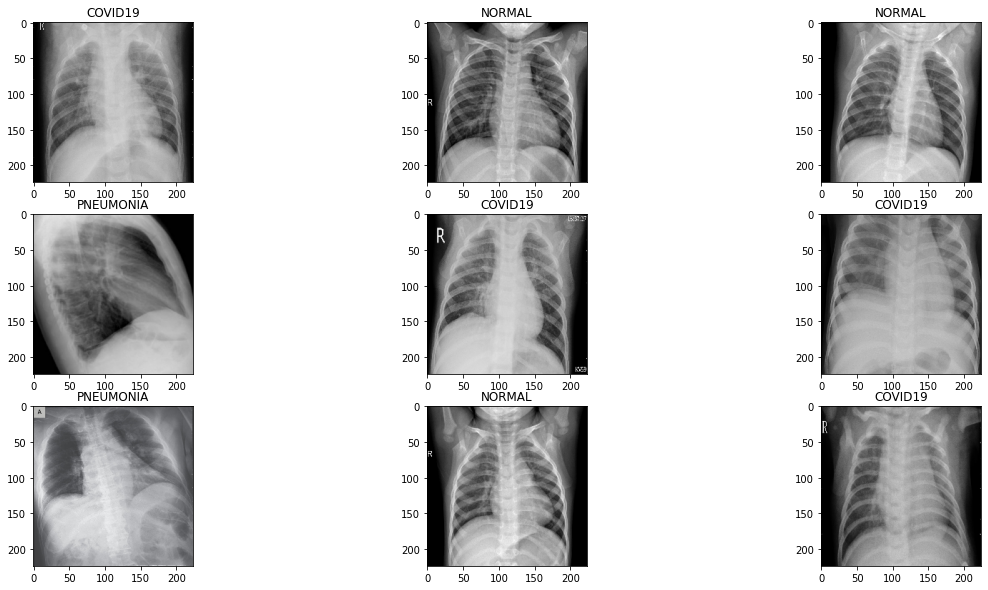

In [11]:
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_dataset.__getitem__(0)[0][i])
    plt.title(getLabel(np.argmax(train_dataset.__getitem__(0)[1][i])) )
  
plt.show()

### Model

In [12]:
densenet = DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

# for layer in densenet.layers:
#   layer.trainable = False


# 뒤에서 20개까지의 레이어는 훈련 가능, 나머지는 가중치 고정
for layer in densenet.layers[:-20]:
    layer.trainable = False 
for layer in densenet.layers[-20:]:
    layer.trainable = True

# densenet.summary()

In [13]:
# tf.keras.utils.plot_model(densenet)

In [14]:
from tensorflow.keras import Model

# x = tf.keras.layers.Flatten()(densenet.output)
x = densenet.layers[-1].output
x = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x)
x = tf.keras.layers.Flatten(name="flatten_head")(x)
x = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x)
x = tf.keras.layers.Dropout(0.5, name="dropout_head")(x)

model = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x)

model = Model(densenet.input, model)

# print(model.summary())

# model.compile(optimizer='adam', loss="binary_crossentropy",metrics=['accuracy'])
model.compile(optimizer='adam', loss="categorical_crossentropy",metrics=['accuracy'])

In [15]:
history = model.fit(train_dataset, steps_per_epoch=20, epochs=epochs )

Epoch 1/40
20/20 [==============================] - 4s 189ms/step - loss: 2.6319 - accuracy: 0.6056
Epoch 2/40
20/20 [==============================] - 4s 196ms/step - loss: 0.7852 - accuracy: 0.8333
Epoch 3/40
20/20 [==============================] - 4s 175ms/step - loss: 0.4323 - accuracy: 0.9000
Epoch 4/40
20/20 [==============================] - 4s 216ms/step - loss: 0.2893 - accuracy: 0.9056
Epoch 5/40
20/20 [==============================] - 4s 203ms/step - loss: 0.2517 - accuracy: 0.9000
Epoch 6/40
20/20 [==============================] - 4s 209ms/step - loss: 0.3016 - accuracy: 0.9000
Epoch 7/40
20/20 [==============================] - 4s 196ms/step - loss: 0.3218 - accuracy: 0.8889
Epoch 8/40
20/20 [==============================] - 4s 190ms/step - loss: 0.3717 - accuracy: 0.8944
Epoch 9/40
20/20 [==============================] - 4s 194ms/step - loss: 0.2541 - accuracy: 0.9111
Epoch 10/40
20/20 [==============================] - 4s 181ms/step - loss: 0.2065 - accuracy: 0.9278

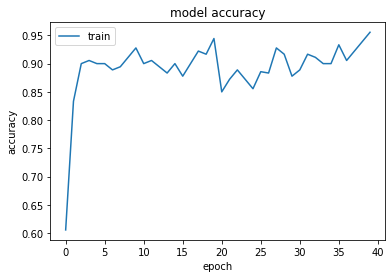

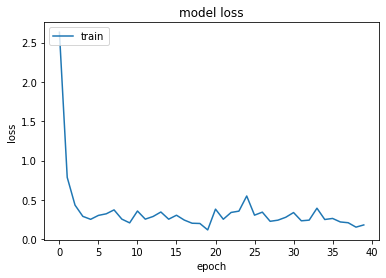

In [16]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [17]:
# model.evaluate(validation_dataset)

model.evaluate(validation_dataset, return_dict=True)

78/78 [==============================] - 16s 199ms/step - loss: 0.0801 - accuracy: 0.9741


{'accuracy': 0.9741379022598267, 'loss': 0.08013445883989334}

In [18]:
# 학습된 모델 저장하기
model.save('modelCovid19_resnet_v2.h5')

# 모델 구조를 json으로 저장하기
json_string = model.to_json()
 
with open("model.json", "w") as f : 
    f.write(json_string)

In [19]:
# 예측하기
pred = model.predict(validation_dataset)

In [20]:
y_test=[]
for i in tqdm(range(78)):
    y_test.extend(validation_dataset.__getitem__(i)[1])

print(len(y_test))
y_test = np.array(y_test)
# print(y_test)


100%|██████████| 78/78 [00:13<00:00,  5.87it/s]

696


In [21]:
y_test=np.argmax(y_test, axis=1)
pred= np.argmax(pred, axis=1)

print("pred: ",len(pred))
print("y_test: ",len(y_test))

# print("y_test \n",y_test)
# print("pred \n",pred)

pred:  696
y_test:  696


In [22]:
from sklearn.metrics import confusion_matrix

# pred = pred[:210]
cm=confusion_matrix(pred,y_test)

print(cm)

[[ 41  56  67]
 [ 55 115 100]
 [ 63  97 102]]


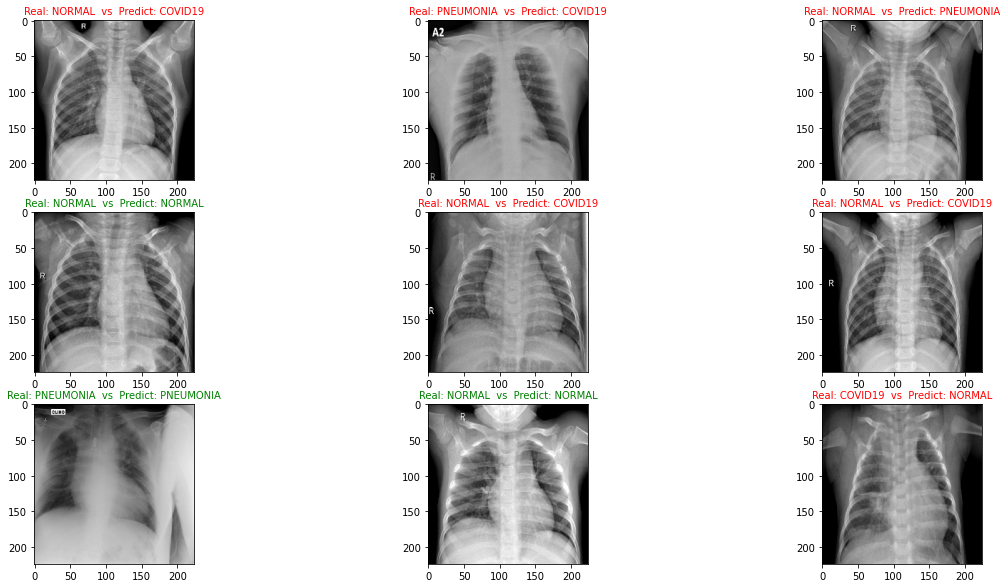

In [23]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(validation_dataset[0][0][i], cmap='gray')
    # plt.imshow(train_dataset.__getitem__(0)[0][i])

    color = "green" if y_test[i] == pred[i] else "red"
    plt.title(f"Real: {getLabel(y_test[i])   }  vs  Predict: {getLabel(pred[i])}", color=color, fontsize=10)

In [24]:
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 41  56  67]
 [ 55 115 100]
 [ 63  97 102]]


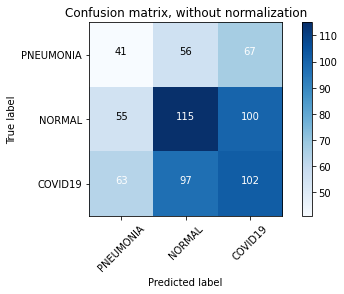

In [25]:
plt.figure()
plot_confusion_matrix(cm, classes=LABELS.keys(), title='Confusion matrix, without normalization')

## 입력 이미지를 이용해서 예측해보기

diseasePredict() 함수 구현

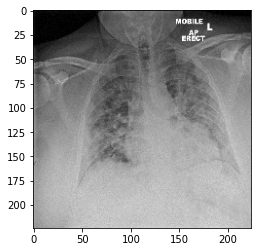

In [26]:
filename = "COVID-1.jpg"
image = f"./predict_test_img/{filename}"

image = cv2.imread(image)
image = cv2.resize(image, (image_size, image_size))

plt.imshow(image, cmap='gray')


In [27]:
# 예측 함수
def diseasePredict(file_path, ml):
    LABELS = {'PNEUMONIA': 0, 'NORMAL': 1, 'COVID19': 2}

    image = cv2.imread(file_path)
    image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)

    reshaped_image = image.reshape((-1, 224, 224, 3))

    pred = ml.predict(reshaped_image)
    pred_code= np.argmax(pred,axis=1)

    disease = getLabel(pred_code)

    return disease


# 예측 이미지 그리기
def showImage(file_path, ml):
    image = cv2.imread(file_path)
    image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)

    plt.imshow(image, cmap='gray')

    disease = diseasePredict(file_path, ml)
    plt.title(disease)
    plt.show()

In [28]:
path = "./predict_test_img/COVID-1.jpg"
ml = model

In [29]:
diseasePredict(path, ml)

'PNEUMONIA'

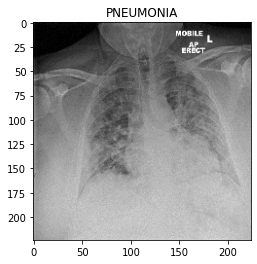

In [30]:
showImage(path, ml)